In [10]:
%matplotlib inline
import torch
import numpy as np
import timeit
import matplotlib.pyplot as plt

# What will we do here

1. Derive the motion of a particle in velocity field
2. Learn how to compute its path


# The motion of particles in a velocity field

Assume we have a wind in 2 or 3D with the components $\vec v(x,y,z,t) = [u(x,y,z,t),v(x,y,z,t),w(x,y,z,t)]$. Then, particle at position
$\vec p = [x,y,z]$ will have the following motion

$$ {\frac d {dt}} {\vec p} = \vec v $$
or more explicitly, restriting ourselves to 2D
\begin{eqnarray*}
{\frac {dx} {dt}} &=& u(x,y,t) \\
{\frac {dy} {dt}} &=& v(x,y,t) 
\end{eqnarray*}

To compute the location of the particle we need to know the velocity field at every point in space and time.
Note that this model neglects momentum and accelaration and therefore is only valid for fields where the motion
is dominated by the wind.



## Integrating the equations in time

The forward Euler method reads
\begin{eqnarray*}
x_{j+1} &=& x_j + hu(x_j,y_j) \\
y_{j+1} &=& y_j + hv(x_j,y_j) 
\end{eqnarray*}

We can also use a higher order approximation
\begin{eqnarray*}
x_{j+1} &=& x_{j-1} + 2hu(x_j,y_j) \\
y_{j+1} &=& y_{j-1} + 2hv(x_j,y_j) 
\end{eqnarray*}

We now propgram these methods


In [18]:
# Forward Euler method
def computeParticlePath(X0,Vfun,h,n):

    X = torch.zeros(2,n+1)
    X[:,0] = X0
    t = 0
    for i in range(n):
        V = Vfun(X[:,i],t)
        X[:,i+1] = X[:,i] + h*V
        t += h
    return X

# midpoint
def computeParticlePathMid(X0,Vfun,h,n):

    X = torch.zeros(2,n+1)
    X[:,0] = X0
    t = 0
    for i in range(n):
        V = Vfun(X[:,i],t)
        if i==0:
            X[:,i+1] = X[:,i] + h*V
        else:
            X[:,i+1] = X[:,i-1] + 2*h*V
        t +=h
    return X





In [ ]:
We now test both methods.

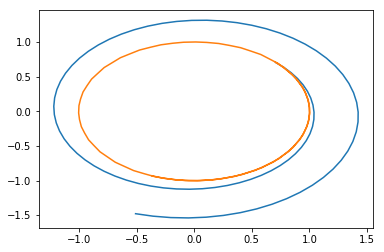

In [26]:
def Vfun(X,t):
    V = torch.zeros(2)
    V[0] = X[1]
    V[1] = -X[0]
    
    return V

X0    = torch.zeros(2); 
X0[0] = 1/np.sqrt(2); 
X0[1] = 1/np.sqrt(2)
h = 0.1
n = np.int(9/h)

XE = computeParticlePath(X0,Vfun,h,n)
XM = computeParticlePathMid(X0,Vfun,h,n)


plt.plot(XE[0,:],XE[1,:],XM[0,:],XM[1,:]);

# Class assignment

We have coded and used two methods and got different results.
1. Which method is better? Why?
2. Can you make the results similar by changing parameters?
3. Think about a different velocity field that gives better/different results using forward Euler?


# Fluid dynamics - Moving more than one particle

When we consider a fluid we can discretize it by many particles. We can view the particles at their initial point as the state of the fluid. We can then the code and see how the particles move in time. This represents the fluid in different points in space/time.

With the code we have we can simply call the single particle code many times, using a for loop. 
A more efficient way to do it in python is to use a vectorized version where we simply propagate all the particles as a 3D array
without calling the loop. 

In [41]:
def computeMultipleParticlePathMid(X0,Vfun,h,n):

    k = X0.shape[0] # number of particles
    X = torch.zeros(k,2,n+1)
    X[:,:,0] = X0
    t = 0
    for i in range(n):
        V = Vfun(X[:,:,i],t)
        if i==0:
            X[:,:,i+1] = X[:,:,i] + h*V
        else:
            X[:,:,i+1] = X[:,:,i-1] + 2*h*V
        t +=h
    return X

# Modified velocity function
def Vfun(X,t):
    m = X.shape
    V = torch.zeros(m[0],2)
    V[:,0] = X[:,1]
    V[:,1] = -X[:,0]
    # add some random pertutrbation for the velocity
    V += 0.1*torch.randn(m) 
    return V

In [44]:
k = 50 # number of particles
X0 = torch.rand(k,2)
h = 0.05
n = np.int(10/h)
X = computeMultipleParticlePathMid(X0,Vfun,h,n)


# Now lets generate some cool graphics (it takes a bit of time)

In [45]:
import matplotlib.animation

nt = X.shape[2]
fig, ax = plt.subplots()
ax.axis([-2,2,-2,2])

# Separate the components of the location
XX = X[:,0,:].squeeze(1)
YY = X[:,1,:].squeeze(1)

def animate(i): 
    ax.plot(XX[:,0:i-1], YY[:,0:i-1],'.w')
    ax.plot(XX[:,i], YY[:,i],'.r')
    
    
%matplotlib inline
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=nt)

from IPython.display import HTML
HTML(ani.to_jshtml())